In [1]:
import os, sys
import copy

sys.path.append("../")
sys.path.append("../../spectral_distortions_perturbations/")
sys.path.append("../../twentyone-global/")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.lines import Line2D
import matplotlib
from scipy.interpolate import interp1d
from tqdm import *

from grf.grf import FIRAS
from twentyone.twentyone import TwentyOne, TwentyOneSolver
from grf.pk_interp import PowerSpectrumGridInterpolator
from decay.units import *
from decay.decay import DecaySpectra

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [74]:
plots_dir = '../../spectral_distortions_perturbations/paper/draft-21cm-features/plots/'
plots_dir = '../../spectral_distortions_perturbations/paper/draft-21cm-features/prl-v3/letter/'
plots_dir = '../../../Dropbox/Projects/21cmFluctuate/21cmFluctuate/Draft/prl-v3/letter/'
plots_resp_dir = '../../../Dropbox/Projects/21cmFluctuate/21cmFluctuate/Draft/prl-v3/response//'

## 21-cm and perturbation classes

In [4]:
to = TwentyOne(z_min=10., z_max=1000., f_star_L=0.03, f_star_X=0.03, T_vir_cut=2e4 * Kelv)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
wr = 6284
im = 528
wr - (im * 6) + ((im / 2) * 3)

3908.0

In [20]:
aspect_ratio = 1.40 * 2
2974 + (300 / (0.5 * aspect_ratio) + 40) * 3

3736.857142857143

In [79]:
aspect_ratio = 1.40 * 2
3129 + (300 / (0.5 * aspect_ratio) + 40) * 3

3891.857142857143

In [21]:
# Define power spectrum for perturbations treatment
pspec = PowerSpectrumGridInterpolator("franken_lower")
firas = FIRAS(pspec)

../../spectral_distortions_perturbations/grf/grf.py:664: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table("../data/firas_monopole_spec_v1.txt", skiprows=18, sep="\s+", header=None, names=["freq", "I", "residual", "uncert", "poles"])


## EDGES fit

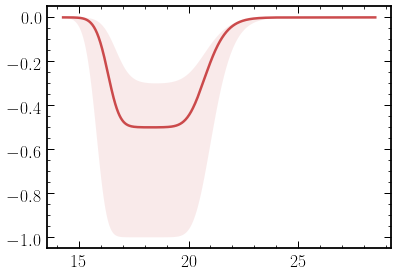

In [22]:
from twentyone.edges import EDGES_fit, opz_to_freq, freq_to_opz

nu_ary = np.linspace(50, 100, 1000)
z_ary = freq_to_opz(nu_ary) - 1
ef = EDGES_fit(z_ary, params="default")
plt.plot(1 + z_ary, ef.T21_fit[0])
plt.fill_between(1 + z_ary, ef.T21_fit[1], ef.T21_fit[2], alpha=0.1)

T21_EDGES = ef.T21_fit[0]
T21_EDGES_min = ef.T21_fit[1]
T21_EDGES_max = ef.T21_fit[2]
z_ary_EDGES = z_ary

## 1. Demonstrative benchmark

In [23]:
spec_dapper = DecaySpectra(pspec)

../../spectral_distortions_perturbations/grf/grf.py:664: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table("../data/firas_monopole_spec_v1.txt", skiprows=18, sep="\s+", header=None, names=["freq", "I", "residual", "uncert", "poles"])


In [24]:
m_Ap = 1e-12 * eV
z_res = spec_dapper.get_z_crossings(m_Ap, spec_dapper.omega_21)[-1]

z_end = 50.
m_a = (1 + z_res) / (z_end + 1) * spec_dapper.omega_21 * 2

tau_a = spec_dapper.tau_a_LL()

print(z_res, m_a / eV)

219.5723166996104 5.103437915794908e-05


In [25]:
z_ary, P_ary, max_rat, eps_max, omega_0 = spec_dapper.get_max_CMB_photon_ratio_z_17(m_Ap, m_a, tau_a, z_at_which_max=70, one_plus_delta_bound=1e2)
max_rat

../decay/decay.py:264: RuntimeWarning: divide by zero encountered in true_divide
  eps_max_ARCADE2 = eps_base * np.sqrt(np.min(dn_CMB_domega_ARCADE2_upper_check / dn_A_domega_ary))


3.400826513930178

In [26]:
eps_max

1.3977914728366787e-09

In [27]:
z_plot = np.logspace(-1, 3, 1000)
spec_dapper.compute_temperature_evolution(m_a, spec_dapper.tau_a_LL() / spec_dapper.tau_u, z_plot, z_ary, omega_0 * P_ary * (1e-9 ** 2 / eps_max ** 2))

In [28]:
plt.rcParams['figure.figsize'] = [6.153846153846153, 4.45]

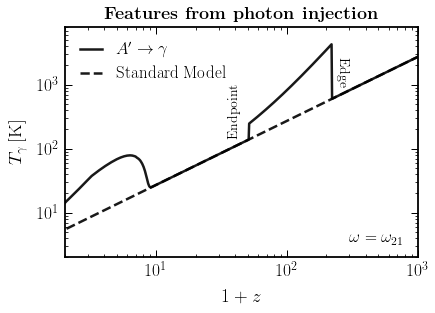

In [31]:
plt.plot(1 + z_plot, spec_dapper.T_CMB_A, color='k', label=r"$A'\rightarrow\gamma$")
plt.plot(1 + z_plot, spec_dapper.T_CMB_SM, color='k', ls='--', label="Standard Model")

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$1 + z$")
plt.ylabel(r"$T_\gamma\,\mathrm{[K]}$")

plt.xlim(2, max(z_plot))
plt.ylim(2, 8e3)
plt.title(r"\bf{Features from photon injection}")

plt.legend(handlelength=1.3)

plt.text(300, 3.5, "$\omega = \omega_{21}$", fontsize=17)

plt.text(240, 1e3, "Edge", rotation=270, fontsize=14)
plt.text(35, 1.5e2, "Endpoint", rotation=90, fontsize=14)

plt.tight_layout()
plt.savefig(plots_dir + "features.pdf")

In [66]:
omega_plot_ary = np.logspace(-7.2, -2.5, 200) * eV
z_ary, dP_dz_ary, _, _, z_ary_homo, P_ary_homo = spec_dapper.P_tot_perturb(omega_plot_ary, eps_max, m_Ap, get_total_prob=1, Ap_DM=0, one_plus_delta_bound=1e2)

../../spectral_distortions_perturbations/grf/grf.py:145: RuntimeWarning: invalid value encountered in sqrt
  m_A_ary = np.nan_to_num(np.sqrt(self.m_A_sq(z_ary, self.omega(omega_0, z_ary, evolve_z))), nan=1e-18 * eV)
../../spectral_distortions_perturbations/grf/grf.py:150: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(np.sqrt(self.m_A_sq(z, self.omega(omega_0, z, evolve_z))), nan=1e-18 * eV) - m_A
../../spectral_distortions_perturbations/grf/grf.py:403: RuntimeWarning: invalid value encountered in log
  pdf_ary = 1 / np.sqrt(2 * np.pi * sigma_LN_sq_ary) * np.exp(-((np.log(1 / b * (m_Ap ** 2 / m_A_sq + b - 1)) + sigma_LN_sq_ary / 2.0) ** 2) / (2 * sigma_LN_sq_ary)) * (1.0 / (m_Ap ** 2 + (b - 1) * m_A_sq))
../../spectral_distortions_perturbations/grf/grf.py:405: RuntimeWarning: invalid value encountered in log
  dP_dz_ary = 1 / np.sqrt(2 * np.pi * sigma_LN_sq_ary) * np.exp(-((np.log(1 / b * (m_Ap ** 2 / m_A_sq + b - 1)) + sigma_LN_sq_ary / 2.0) ** 2) / (2 * sigm

In [67]:
P_ary = (dP_dz_ary[:, 1:] + dP_dz_ary[:, :-1]) / 2.0 * np.diff(z_ary)
z_res_ary = (z_ary[1:] + z_ary[:-1]) / 2.0

In [68]:
dn_A_domega_plot_ary = []
dn_Ap_domega_plot_ary = []

for i_omega, omega in enumerate(omega_plot_ary):
    dn_A_domega_temp, dn_Ap_domega_temp = spec_dapper.dn_A_domega(m_a=m_a, z=0, z_res_ary=np.concatenate([z_res_ary, z_ary_homo[i_omega]]), P_ary=np.concatenate([P_ary[i_omega], P_ary_homo[i_omega]]), omega=omega, tau_a=tau_a, return_Ap_spec=True)
    dn_A_domega_plot_ary.append(dn_A_domega_temp)
    dn_Ap_domega_plot_ary.append(dn_Ap_domega_temp)
    
dn_A_domega_plot_ary = np.array(dn_A_domega_plot_ary)
dn_Ap_domega_plot_ary = np.array(dn_Ap_domega_plot_ary)

In [69]:
# Check to make sure we get right CMB photon density
np.trapz(spec_dapper.dn_CMB_domega(omega_plot_ary, z=0, T_0=2.7255), omega_plot_ary) / (Centimeter ** -3)

410.87630704747534

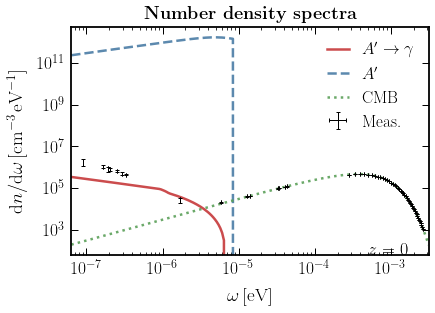

In [73]:
dn_CMB_domega_ARCADE2_mean = spec_dapper.dn_CMB_domega(spec_dapper.omega_ARCADE2_ary, z=0, T_0=spec_dapper.T_ARCADE2_fid) *  eV / (Centimeter ** -3)
dn_CMB_domega_ARCADE2_upper = spec_dapper.dn_CMB_domega(spec_dapper.omega_ARCADE2_ary, z=0, T_0=spec_dapper.T_ARCADE2_fid + spec_dapper.T_ARCADE2_unc) *  eV / (Centimeter ** -3)
dn_CMB_domega_ARCADE2_lower = spec_dapper.dn_CMB_domega(spec_dapper.omega_ARCADE2_ary, z=0, T_0=spec_dapper.T_ARCADE2_fid - spec_dapper.T_ARCADE2_unc) *  eV / (Centimeter ** -3)

dn_CMB_domega_radio_mean = spec_dapper.dn_CMB_domega(spec_dapper.omega_radio_ary, z=0, T_0=spec_dapper.T_radio_fid) *  eV / (Centimeter ** -3)
dn_CMB_domega_radio_upper = spec_dapper.dn_CMB_domega(spec_dapper.omega_radio_ary, z=0, T_0=spec_dapper.T_radio_fid + spec_dapper.T_radio_unc) *  eV / (Centimeter ** -3)
dn_CMB_domega_radio_lower = spec_dapper.dn_CMB_domega(spec_dapper.omega_radio_ary, z=0, T_0=spec_dapper.T_radio_fid - 2 * spec_dapper.T_radio_unc) *  eV / (Centimeter ** -3)

dn_CMB_domega_llfss_mean = spec_dapper.dn_CMB_domega(spec_dapper.omega_llfss_ary, z=0, T_0=spec_dapper.T_llfss_fid) *  eV / (Centimeter ** -3)
dn_CMB_domega_llfss_upper = spec_dapper.dn_CMB_domega(spec_dapper.omega_llfss_ary, z=0, T_0=spec_dapper.T_llfss_fid + spec_dapper.T_llfss_unc) *  eV / (Centimeter ** -3)
dn_CMB_domega_llfss_lower = spec_dapper.dn_CMB_domega(spec_dapper.omega_llfss_ary, z=0, T_0=spec_dapper.T_llfss_fid - spec_dapper.T_llfss_unc) *  eV / (Centimeter ** -3)

plt.plot(omega_plot_ary / eV, np.array(dn_A_domega_plot_ary) / eV ** -1 / (Centimeter ** -3), label=r'$A^\prime\rightarrow\gamma$') 
plt.plot(omega_plot_ary / eV, np.array(dn_Ap_domega_plot_ary) / eV ** -1 / (Centimeter ** -3), label=r'$A^\prime$', ls='--') 
plt.plot(omega_plot_ary / eV, spec_dapper.dn_CMB_domega(omega_plot_ary, z=0, T_0=2.7255) / eV ** -1 / (Centimeter ** -3), label="CMB", ls=':')

I = firas.d * (1e6 * Jy) / (firas.omega_FIRAS / (4 * np.pi)) / eV ** -1 / (2 * np.pi)
dI = firas.df['uncert'].values * (1e6 * Jy) / (firas.omega_FIRAS / (4 * np.pi)) / eV ** -1 / (2 * np.pi) / 1e3

plt.errorbar(firas.omega_FIRAS / eV , I / (Centimeter ** -3), xerr=0, yerr=dI, c='k', fmt='none', capsize=2, capthick=1, elinewidth=1.)

plt.errorbar(spec_dapper.omega_ARCADE2_ary / eV, np.array(dn_CMB_domega_ARCADE2_mean), xerr=0, yerr=[dn_CMB_domega_ARCADE2_mean - dn_CMB_domega_ARCADE2_lower, 
                                                                                                     dn_CMB_domega_ARCADE2_upper - dn_CMB_domega_ARCADE2_mean],
            c='k', fmt='none', capsize=2, capthick=1, elinewidth=1.)

plt.errorbar(spec_dapper.omega_radio_ary / eV, np.array(dn_CMB_domega_radio_mean), xerr=0, yerr=[dn_CMB_domega_radio_mean - dn_CMB_domega_radio_lower,
                                                                                                 dn_CMB_domega_radio_upper - dn_CMB_domega_radio_mean],
            c='k', fmt='none', capsize=2, capthick=1, elinewidth=1.)

plt.errorbar(spec_dapper.omega_llfss_ary / eV, np.array(dn_CMB_domega_llfss_mean), xerr=0, yerr=[dn_CMB_domega_llfss_mean - dn_CMB_domega_llfss_lower,
                                                                                                 dn_CMB_domega_llfss_upper - dn_CMB_domega_llfss_mean 
                                                                                                 ],
            c='k', fmt='none', capsize=2, capthick=1, elinewidth=1., label="Meas.")

# plt.plot(omega_plot_ary / eV, spec_dapper.dn_CMB_domega(omega_plot_ary, z=0, T_0=spec_dapper.T_eg(omega_plot_ary / (2 * np.pi))) *  eV / (Centimeter ** -3), ls=':', label="EG power law")

plt.xlabel(r"$\omega$\,[eV]")
plt.ylabel(r"$\mathrm dn/\mathrm d\omega$\,[cm$^{-3}$\,eV$^{-1}$]")

plt.xscale("log")
plt.yscale("log")

plt.xlim(min(omega_plot_ary / eV), max(omega_plot_ary / eV))
# plt.ylim(1e1, 1e12)
plt.legend(handlelength=1.3, loc="upper right")

plt.text(5e-4, 5e-22 / (Centimeter ** -3), "$z=0$", fontsize=18)

plt.title(r"\bf{Number density spectra}")

ax = plt.gca()

# locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
# # ax.xaxis.set_major_locator(locmaj)
# ax.yaxis.set_major_locator(locmaj)

plt.tight_layout()
plt.savefig(plots_dir + "dn_domega.pdf")

## Include EG background, for ref. response

../decay/decay.py:150: RuntimeWarning: overflow encountered in exp
  return 8 * np.pi * (omega / (2 * np.pi)) ** 2 * 1 / (np.exp(omega / self.T_CMB(z, T_0)) - 1) / (2 * np.pi)


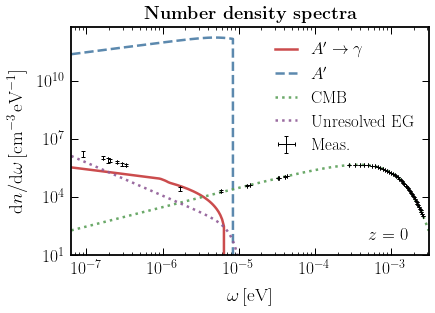

In [76]:
dn_CMB_domega_ARCADE2_mean = spec_dapper.dn_CMB_domega(spec_dapper.omega_ARCADE2_ary, z=0, T_0=spec_dapper.T_ARCADE2_fid) *  eV / (Centimeter ** -3)
dn_CMB_domega_ARCADE2_upper = spec_dapper.dn_CMB_domega(spec_dapper.omega_ARCADE2_ary, z=0, T_0=spec_dapper.T_ARCADE2_fid + spec_dapper.T_ARCADE2_unc) *  eV / (Centimeter ** -3)
dn_CMB_domega_ARCADE2_lower = spec_dapper.dn_CMB_domega(spec_dapper.omega_ARCADE2_ary, z=0, T_0=spec_dapper.T_ARCADE2_fid - spec_dapper.T_ARCADE2_unc) *  eV / (Centimeter ** -3)

dn_CMB_domega_radio_mean = spec_dapper.dn_CMB_domega(spec_dapper.omega_radio_ary, z=0, T_0=spec_dapper.T_radio_fid) *  eV / (Centimeter ** -3)
dn_CMB_domega_radio_upper = spec_dapper.dn_CMB_domega(spec_dapper.omega_radio_ary, z=0, T_0=spec_dapper.T_radio_fid + spec_dapper.T_radio_unc) *  eV / (Centimeter ** -3)
dn_CMB_domega_radio_lower = spec_dapper.dn_CMB_domega(spec_dapper.omega_radio_ary, z=0, T_0=spec_dapper.T_radio_fid - 2 * spec_dapper.T_radio_unc) *  eV / (Centimeter ** -3)

dn_CMB_domega_llfss_mean = spec_dapper.dn_CMB_domega(spec_dapper.omega_llfss_ary, z=0, T_0=spec_dapper.T_llfss_fid) *  eV / (Centimeter ** -3)
dn_CMB_domega_llfss_upper = spec_dapper.dn_CMB_domega(spec_dapper.omega_llfss_ary, z=0, T_0=spec_dapper.T_llfss_fid + spec_dapper.T_llfss_unc) *  eV / (Centimeter ** -3)
dn_CMB_domega_llfss_lower = spec_dapper.dn_CMB_domega(spec_dapper.omega_llfss_ary, z=0, T_0=spec_dapper.T_llfss_fid - spec_dapper.T_llfss_unc) *  eV / (Centimeter ** -3)

plt.plot(omega_plot_ary / eV, np.array(dn_A_domega_plot_ary) / eV ** -1 / (Centimeter ** -3), label=r'$A^\prime\rightarrow\gamma$') 
plt.plot(omega_plot_ary / eV, np.array(dn_Ap_domega_plot_ary) / eV ** -1 / (Centimeter ** -3), label=r'$A^\prime$', ls='--') 
plt.plot(omega_plot_ary / eV, spec_dapper.dn_CMB_domega(omega_plot_ary, z=0, T_0=2.7255) / eV ** -1 / (Centimeter ** -3), label="CMB", ls=':')

I = firas.d * (1e6 * Jy) / (firas.omega_FIRAS / (4 * np.pi)) / eV ** -1 / (2 * np.pi)
dI = firas.df['uncert'].values * (1e6 * Jy) / (firas.omega_FIRAS / (4 * np.pi)) / eV ** -1 / (2 * np.pi) / 1e3

plt.errorbar(firas.omega_FIRAS / eV , I / (Centimeter ** -3), xerr=0, yerr=dI, c='k', fmt='none', capsize=2, capthick=1, elinewidth=1.)

plt.errorbar(spec_dapper.omega_ARCADE2_ary / eV, np.array(dn_CMB_domega_ARCADE2_mean), xerr=0, yerr=[dn_CMB_domega_ARCADE2_mean - dn_CMB_domega_ARCADE2_lower, 
                                                                                                     dn_CMB_domega_ARCADE2_upper - dn_CMB_domega_ARCADE2_mean],
            c='k', fmt='none', capsize=2, capthick=1, elinewidth=1.)

plt.errorbar(spec_dapper.omega_radio_ary / eV, np.array(dn_CMB_domega_radio_mean), xerr=0, yerr=[dn_CMB_domega_radio_mean - dn_CMB_domega_radio_lower,
                                                                                                 dn_CMB_domega_radio_upper - dn_CMB_domega_radio_mean],
            c='k', fmt='none', capsize=2, capthick=1, elinewidth=1.)

plt.errorbar(spec_dapper.omega_llfss_ary / eV, np.array(dn_CMB_domega_llfss_mean), xerr=0, yerr=[dn_CMB_domega_llfss_mean - dn_CMB_domega_llfss_lower,
                                                                                                 dn_CMB_domega_llfss_upper - dn_CMB_domega_llfss_mean 
                                                                                                 ],
            c='k', fmt='none', capsize=2, capthick=1, elinewidth=1., label="Meas.")

plt.plot(omega_plot_ary / eV, spec_dapper.dn_CMB_domega(omega_plot_ary, z=0, T_0=spec_dapper.T_eg(omega_plot_ary / (2 * np.pi))) *  eV / (Centimeter ** -3), ls=':', label="Unresolved EG")

plt.xlabel(r"$\omega$\,[eV]")
plt.ylabel(r"$\mathrm dn/\mathrm d\omega$\,[cm$^{-3}$\,eV$^{-1}$]")

plt.xscale("log")
plt.yscale("log")

plt.xlim(min(omega_plot_ary / eV), max(omega_plot_ary / eV))
plt.ylim(1e1, 6e12)
plt.legend(handlelength=1.3, loc="upper right")

plt.text(5e-4, 5e-22 / (Centimeter ** -3), "$z=0$", fontsize=18)

plt.title(r"\bf{Number density spectra}")

ax = plt.gca()

# locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
# # ax.xaxis.set_major_locator(locmaj)
# ax.yaxis.set_major_locator(locmaj)

plt.tight_layout()
plt.savefig(plots_resp_dir + "dn_domega_EG.pdf")

## 2. EDGES window

In [36]:
spec_edges = DecaySpectra(pspec)

../../spectral_distortions_perturbations/grf/grf.py:664: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table("../data/firas_monopole_spec_v1.txt", skiprows=18, sep="\s+", header=None, names=["freq", "I", "residual", "uncert", "poles"])


In [37]:
# m_Ap = 3.2e-12 * eV
m_Ap = 1e-11 * eV

tau_a = spec_edges.tau_a_LL()

z_res = spec_edges.get_z_crossings(m_Ap, spec_edges.omega_21)[-1]

z_end = 15.
m_a = (1 + z_res) / (1 + z_end) * spec_edges.omega_21 * 2

print(z_res, m_a / eV)

663.3749430196248 0.0004899765204769733


In [38]:
z_ary, P_ary, max_rat, eps_max, omega_0 = spec_edges.get_max_CMB_photon_ratio_z_17(m_Ap, m_a, tau_a, z_at_which_max=17, one_plus_delta_bound=1e2, include_eg=True)
max_rat

30.879928090815874

In [39]:
eps_max

1.3340685318027042e-07

In [40]:
eps_max * np.sqrt(4.4 / max_rat)

5.0357752401224585e-08

In [41]:
rat_P = 4.4 / max_rat
rat_P

0.14248737843753667

In [42]:
z_plot = np.logspace(-1, 3, 1000)
spec_edges.compute_temperature_evolution(m_a, spec_edges.tau_a_LL() / spec_edges.tau_u, z_plot, z_ary, rat_P * omega_0 * P_ary)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1170: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  red, np.inf)[0]
/Users/smsharma/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1170: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  red, np.inf)[0]
/Users/smsharma/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1170: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  red, np.inf)[0]
/Users/smsharma/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1170: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  red, np.inf)[0]
/Users/smsharma/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1170: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  red, np.inf)[0]


In [43]:
z_max = 700.
z_min = 11.
z_21_ary = np.logspace(np.log10(z_min), np.log10(z_max), 1000)[:: -1]

In [44]:
to_noX = copy.copy(to) 
to_noX.mod_f_star(f_star_L=0.03, f_star_X=0.3 * 0.03, T_vir_cut=2e4 * Kelv)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:
T_gamma_SM = lambda z: to.T_CMB(z)
to_SM_solve = TwentyOneSolver(T_gamma=T_gamma_SM, to=to, z_ary=z_21_ary)
to_SM_solution = to_SM_solve.solve()

In [46]:
T_end_15_interp = interp1d(z_plot, spec_edges.T_CMB_A)

T_gamma = lambda z: T_end_15_interp(z)
T_end_15_solve = TwentyOneSolver(T_gamma=T_gamma, to=to_noX, z_ary=z_21_ary)
T_end_15_solution = T_end_15_solve.solve()

In [47]:
spec_edges.get_powerlaw_params()

T_CMB_mod_ary = spec_edges.T_CMB_powerlaw_ary(z_plot, 0.020)

T_powerlaw_interp = interp1d(z_plot, T_CMB_mod_ary)

T_gamma = lambda z: T_powerlaw_interp(z)
T_powerlaw_solve = TwentyOneSolver(T_gamma=T_gamma, to=to, z_ary=z_21_ary)
T_powerlaw_solution = T_powerlaw_solve.solve()

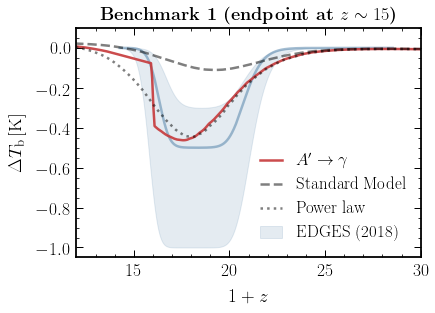

In [63]:
fig, ax = plt.subplots()

plt.plot(1 + z_ary_EDGES,T21_EDGES, alpha=0.5, color=cols_default[1])
plt.fill_between(1 + z_ary_EDGES, T21_EDGES_min, T21_EDGES_max, alpha=0.15, color=cols_default[1], label='EDGES (2018)')
plt.plot(1 + T_end_15_solve.z_ary, T_end_15_solve.delta_T_b_ary, label=r'$A^\prime \rightarrow \gamma$', alpha=0.9, color=cols_default[0])
plt.plot(1 + to_SM_solve.z_ary, to_SM_solve.delta_T_b_ary, label='Standard Model', color='k', alpha=0.5, ls='--')
plt.plot(1 + T_powerlaw_solve.z_ary, T_powerlaw_solve.delta_T_b_ary, label='Power law', color='k', alpha=0.5, ls=':')

plt.xlabel("$1 + z$")
plt.ylabel("$\Delta T_{\mathrm b}\,\mathrm{[K]}$")
plt.title(r"\bf{Benchmark 1}  (endpoint at $z\sim 15$)")

plt.legend(loc='lower right', handlelength=1.3)

plt.xlim(np.min(1 + T_end_15_solve.z_ary), 30)

# plt.xscale("log")

plt.ylim(-1.05, 0.1)

plt.tight_layout()

# plt.text(13, -1.14, r"$\epsilon=10^{-8}$", fontsize=14)
# plt.text(13, -1.06, r"$m_{\gamma^\prime} = 4.7\times 10^{-13}\,\mathrm{eV}, m_{a} = 10^{-4}\,\mathrm{eV}$", fontsize=14)

# plt.savefig(plots_dir + "T_b_z_res_130.pdf", bbox_inches='tight',pad_inches = 0.05)

plt.savefig(plots_dir + "delta_T_b_1.pdf")

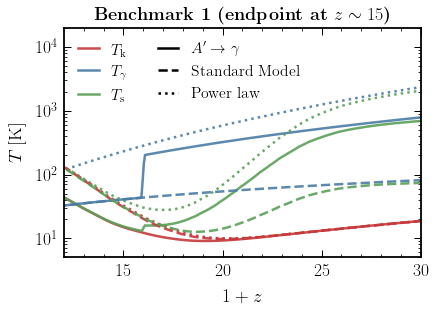

In [62]:
fig, ax = plt.subplots()

ax.plot(1 + T_end_15_solve.z_ary, T_end_15_solve.T_k_ary, label='$T_\mathrm{k}$', color=cols_default[0])
ax.plot(1 + T_end_15_solve.z_ary, T_end_15_solve.T_gamma_ary, label='$T_\gamma$', color=cols_default[1])
ax.plot(1 + T_end_15_solve.z_ary, T_end_15_solve.T_s_ary, label='$T_\mathrm{s}$', color=cols_default[2])

ax.plot(1 + T_powerlaw_solve.z_ary, T_powerlaw_solve.T_k_ary, label='$T_\mathrm{k}$', color=cols_default[0], ls=':')
ax.plot(1 + T_powerlaw_solve.z_ary, T_powerlaw_solve.T_gamma_ary, label='$T_\gamma$', color=cols_default[1], ls=':')
ax.plot(1 + T_powerlaw_solve.z_ary, T_powerlaw_solve.T_s_ary, label='$T_\mathrm{s}$', color=cols_default[2], ls=':')

ax.plot(1 + to_SM_solve.z_ary, to_SM_solve.T_k_ary, label='$T_k$', color=cols_default[0], ls='--')
ax.plot(1 + to_SM_solve.z_ary, to_SM_solve.T_gamma_ary, label='$T_\gamma$', color=cols_default[1], ls='--')
ax.plot(1 + to_SM_solve.z_ary, to_SM_solve.T_s_ary, label='$T_s$', color=cols_default[2], ls='--')

ax.set_xlabel("$1 + z$")
ax.set_ylabel("$T\,\mathrm{[K]}$")
ax.set_title(r"\bf{Benchmark 1}  (endpoint at $z\sim 15$)")

ax.set_yscale("log")
# plt.xscale("log")

ax.set_xlim(np.min(1 + to_SM_solve.z_ary), 30)
ax.set_ylim(5, 2e4)

plt.tight_layout()

handles,labels = ax.get_legend_handles_labels()

custom_lines = [Line2D([0], [0], color='k', linestyle=ls) for ls in ['-','--',':']]
custom_labels = [r'$A^\prime \rightarrow \gamma$', 'Standard Model', 'Power law']

# Modify them with new legend marker and label
handles = list(handles[:3]) + custom_lines
labels = list(labels[:3]) + custom_labels

ax.legend(handles, labels, ncol=2, handlelength=1.3, fontsize=15.8)

plt.savefig(plots_dir + "T_evol_1.pdf")

## 3. Injection

In [50]:
spec_dapper2 = DecaySpectra(pspec)

../../spectral_distortions_perturbations/grf/grf.py:664: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table("../data/firas_monopole_spec_v1.txt", skiprows=18, sep="\s+", header=None, names=["freq", "I", "residual", "uncert", "poles"])


In [51]:
m_Ap = 10 ** -12.6 * eV
z_res = spec_dapper2.get_z_crossings(m_Ap, spec_edges.omega_21)[-1]

z_end = 65.
m_a = (1 + z_res) / (z_end + 1) * spec_dapper2.omega_21 * 2

print(z_res, m_a / eV)

94.92564698059199 1.7150342945014933e-05


In [52]:
z_ary, P_ary, max_rat, eps_max, omega_0 = spec_dapper2.get_max_CMB_photon_ratio_z_17(m_Ap, m_a, tau_a, z_at_which_max=70, one_plus_delta_bound=1e2, include_eg=True)
max_rat

3.1488744119192713

In [53]:
eps_max

4.5009364023624927e-10

In [54]:
z_plot = np.logspace(-1, 3, 1000)
spec_dapper2.compute_temperature_evolution(m_a, spec_dapper2.tau_a_LL() / spec_dapper2.tau_u, z_plot, z_ary, omega_0 * P_ary)

In [55]:
T_DAPPEr2_interp = interp1d(z_plot, spec_dapper2.T_CMB_A)

T_gamma = lambda z: T_DAPPEr2_interp(z)
T_DAPPEr2_solve = TwentyOneSolver(T_gamma=T_gamma, to=to, z_ary=z_21_ary)
T_DAPPEr2_solution = T_DAPPEr2_solve.solve()

In [56]:
spec_dapper2.get_powerlaw_params()

T_CMB_mod_ary = spec_dapper2.T_CMB_powerlaw_ary(z_plot, 0.0001)
T_powerlaw2_interp = interp1d(z_plot, T_CMB_mod_ary)

T_gamma = lambda z: T_powerlaw2_interp(z)
T_powerlaw2_solve = TwentyOneSolver(T_gamma=T_gamma, to=to, z_ary=z_21_ary)
T_powerlaw2_solution = T_powerlaw2_solve.solve()

In [57]:
# z = np.logspace(np.log10(np.min(T_end_15_solve.z_ary)), np.log10(120), 10)
# spec_edges.omega_21 / ( 1 + z) / (1e6 * Hz) / (2 * np.pi)

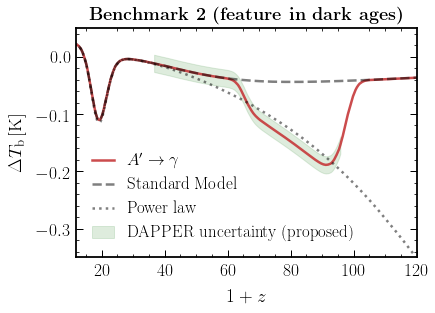

In [60]:
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)

fig, ax = plt.subplots()
# ax.tick_params(labelleft=False)    

# ax.plot(1 + z_ary_EDGES,T21_EDGES, alpha=0.5, color=cols_default[1])
# ax.fill_between(1 + z_ary_EDGES, T21_EDGES_min, T21_EDGES_max, alpha=0.15, color=cols_default[1], label='EDGES (2018)')
ax.plot(1 + T_DAPPEr2_solve.z_ary, T_DAPPEr2_solve.delta_T_b_ary, label=r'$A^\prime \rightarrow \gamma$', alpha=0.9, color=cols_default[0])
ax.plot(1 + to_SM_solve.z_ary, to_SM_solve.delta_T_b_ary, label='Standard Model', color='k', alpha=0.5, ls='--')
ax.plot(1 + T_powerlaw2_solve.z_ary, T_powerlaw2_solve.delta_T_b_ary, label='Power law', color='k', alpha=0.5, ls=':')

cond = (to_SM_solve.z_ary < freq_to_opz(15)) * (to_SM_solve.z_ary > freq_to_opz(40))
ax.fill_between(1 + to_SM_solve.z_ary[cond], np.array(T_DAPPEr2_solve.delta_T_b_ary)[cond] - 15e-3, np.array(T_DAPPEr2_solve.delta_T_b_ary)[cond] + 15e-3, alpha=0.2, color=cols_default[2], label="DAPPER uncertainty (proposed)")



ax.set_xlabel("$1 + z$")
ax.set_ylabel("$\Delta T_{\mathrm b}\,\mathrm{[K]}$")
ax.set_title(r"\bf{Benchmark 2} (feature in dark ages)")

ax.legend(loc='lower left', handlelength=1.3)

ax.set_xlim(np.min(1 + T_DAPPEr2_solve.z_ary), 120)

# ax.set_xscale("log")

ax.set_ylim(-.35, 0.05)

# secax = ax.secondary_xaxis('top', functions=(opz_to_freq, freq_to_opz))
# secax = ax.secondary_xaxis('top')


# # secax.xaxis.set_minor_locator(AutoMinorLocator())
# secax.set_xlabel(r"$\nu$\,[MHz]")
# secax.set_xticks([])
# secax.set_xticks([])
# secax.set_xticks(1 / np.array([50, 30, 20, 12]))
# secax.set_xticklabels(np.array([50, 30, 20, 12]))
# # secax.xaxis.set_minor_locator(AutoMinorLocator())
# # secax.xaxis.set_major_locator(AutoLocator())

# secax.tick_params(top=False, labeltop=False)
ax.tick_params(top=False, labeltop=False)

plt.tight_layout()

# plt.text(13, -1.14, r"$\epsilon=10^{-8}$", fontsize=14)
# plt.text(13, -1.06, r"$m_{\gamma^\prime} = 4.7\times 10^{-13}\,\mathrm{eV}, m_{a} = 10^{-4}\,\mathrm{eV}$", fontsize=14)

# plt.savefig(plots_dir + "T_b_z_res_130.pdf", bbox_inches='tight',pad_inches = 0.05)

plt.savefig(plots_dir + "delta_T_b_2.pdf")

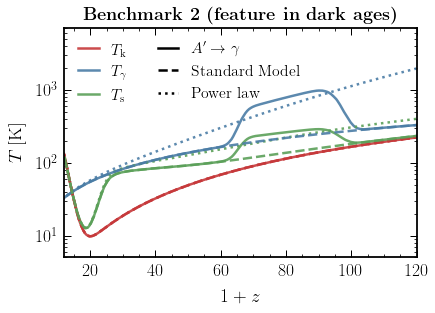

In [61]:
fig, ax = plt.subplots()

ax.plot(1 + T_DAPPEr2_solve.z_ary, T_DAPPEr2_solve.T_k_ary, label='$T_\mathrm{k}$', color=cols_default[0])
ax.plot(1 + T_DAPPEr2_solve.z_ary, T_DAPPEr2_solve.T_gamma_ary, label='$T_\gamma$', color=cols_default[1])
ax.plot(1 + T_DAPPEr2_solve.z_ary, T_DAPPEr2_solve.T_s_ary, label='$T_\mathrm{s}$', color=cols_default[2])

ax.plot(1 + T_powerlaw2_solve.z_ary, T_powerlaw2_solve.T_k_ary, label='$T_\mathrm{k}$', color=cols_default[0], ls=':')
ax.plot(1 + T_powerlaw2_solve.z_ary, T_powerlaw2_solve.T_gamma_ary, label='$T_\gamma$', color=cols_default[1], ls=':')
ax.plot(1 + T_powerlaw2_solve.z_ary, T_powerlaw2_solve.T_s_ary, label='$T_\mathrm{s}$', color=cols_default[2], ls=':')

ax.plot(1 + to_SM_solve.z_ary, to_SM_solve.T_k_ary, label='$T_k$', color=cols_default[0], ls='--')
ax.plot(1 + to_SM_solve.z_ary, to_SM_solve.T_gamma_ary, label='$T_\gamma$', color=cols_default[1], ls='--')
ax.plot(1 + to_SM_solve.z_ary, to_SM_solve.T_s_ary, label='$T_s$', color=cols_default[2], ls='--')

ax.set_xlabel("$1 + z$")
ax.set_ylabel("$T\,\mathrm{[K]}$")
ax.set_title(r"\bf{Benchmark 2} (feature in dark ages)")

ax.set_yscale("log")
# plt.xscale("log")

ax.set_xlim(1 + np.min(to_SM_solve.z_ary), 120)
ax.set_ylim(5, 7e3)

plt.tight_layout()

handles,labels = ax.get_legend_handles_labels()

custom_lines = [Line2D([0], [0], color='k', linestyle=ls) for ls in ['-','--',':']]
custom_labels = [r'$A^\prime \rightarrow \gamma$', 'Standard Model', 'Power law']

# Modify them with new legend marker and label
handles = list(handles[:3]) + custom_lines
labels = list(labels[:3]) + custom_labels

ax.legend(handles, labels, ncol=2, handlelength=1.3, fontsize=15.8)

plt.savefig(plots_dir + "T_evol_2.pdf")

## Maximum possible absorption in SM

In [335]:
to_WF = TwentyOne(z_min=10., z_max=40., f_star_L=0.03, f_star_X=1e-10, T_vir_cut=1e4 * Kelv)

In [336]:
z_max = 30.
z_min = 11.
z_21_ary = np.logspace(np.log10(z_min), np.log10(z_max), 100)[:: -1]

In [337]:
T_gamma_SM = lambda z: to.T_CMB(z)
to_WF_solve = TwentyOneSolver(T_gamma=T_gamma_SM, to=to_WF, z_ary=z_21_ary, perfect_WF=True)
to_WF_solution = to_WF_solve.solve()

In [338]:
np.min(to_WF_solve.delta_T_b_ary)

-0.2138169547414997

In [42]:
to.M_min(2e4 * Kelv, 20) / M_s / 1e7

array([8.96982226])

## Typical $\epsilon$ values

In [125]:
spec_typical = DecaySpectra(pspec)

../../spectral_distortions_perturbations/grf/grf.py:663: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table("../data/firas_monopole_spec_v1.txt", skiprows=18, sep="\s+", header=None, names=["freq", "I", "residual", "uncert", "poles"])


In [154]:
m_Ap = 1 * 10 ** -9 * eV
m_a = 4 * 10 ** -3 * eV

In [155]:
z_ary, P_ary, max_rat, eps_max, omega_0 = spec_typical.get_max_CMB_photon_ratio_z_17(m_Ap, m_a, tau_a, z_at_which_max=17, one_plus_delta_bound=1e2)
max_rat

525.2704197506306

In [156]:
eps_max * np.sqrt(4. / max_rat)

1.859447170734225e-08

In [ ]:
5.0005998545661845e-08
7.097061423709747e-09
4.963439156824648e-08
1.4345953076266737e-06
8.211197896611458e-08
2.1355052421136844e-07